In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt

In [2]:
df_test = pd.read_csv('./input/test.csv')
all_data = pd.read_csv('all_data_new.csv')

In [3]:
to_drop_cols = ['target_item_avg', 'target_item', 'target', 'target_shop_avg', 'target_shop', 'date_block_num']

In [4]:
X_train = all_data[all_data['date_block_num']<33]
Y_train = X_train['target']
X_train = X_train.drop(to_drop_cols,axis=1)

X_val = all_data[all_data['date_block_num']==33]
Y_val = X_val['target']
X_val = X_val.drop(to_drop_cols,axis=1)

X_test = all_data[all_data['date_block_num']==34]
X_test = X_test.drop(to_drop_cols,axis=1)

In [5]:
Y_train.clip(0,40,inplace=True)
Y_val.clip(0,40,inplace=True)

/home/chiayi/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [6]:
params = {
        'eta': 0.08, #best 0.08
        'max_depth': 7,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'seed': 3,
        'gamma':1,
        'silent': True
}

watchlist = [(xgb.DMatrix(X_train, Y_train), 'train'), (xgb.DMatrix(X_val, Y_val), 'valid')]
model = xgb.train(params, xgb.DMatrix(X_train, Y_train), 100,  watchlist, maximize=False, verbose_eval=50, early_stopping_rounds=50)

[0]	train-rmse:1.4022	valid-rmse:1.37368
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992071	valid-rmse:1.10188
[99]	train-rmse:0.962668	valid-rmse:1.09596


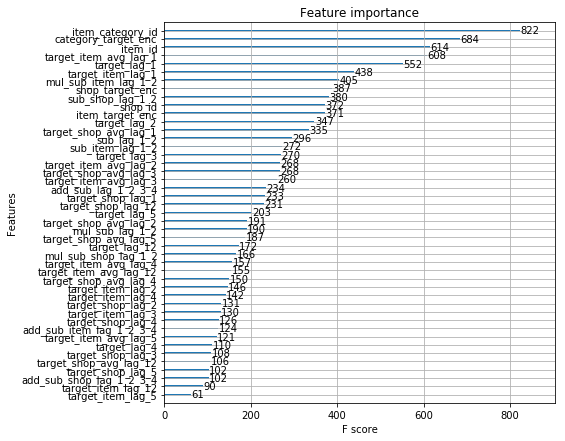

In [7]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=model)

In [8]:
pickle.dump(model, open("xgb.pickle.dat", "wb"))

pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)

df_test['item_cnt_month'] = pred.clip(0,20)
df_test.drop(['shop_id','item_id'],axis=1,inplace=True)
df_test.to_csv('submission.csv', index=False)